# Train Models, Tune Hyper Parameters and Compare Performance

In this notebook, I will train (or rather fine-tune) multiple models,
tune their hyperparameters, evaluate and compare their performance,
select a final model and evaluate its performance on the test set.

## Preparations

In [26]:
# Dependencies
import requests
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from statistics import mean
from statistics import stdev

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models


In [27]:
# Paths
PATH_DATA_PROCESSED = Path("../data/processed")
PATH_DATA_TRAIN = PATH_DATA_PROCESSED / "train"
PATH_DATA_TEST = PATH_DATA_PROCESSED / "test"
PATH_MODELS = Path("../models")

In [28]:
# set device based on available hardware
device = (
    "mps" if torch.backends.mps.is_available() # for Apple Silicon chips
    else "cuda" if torch.cuda.is_available() # for NVIDIA GPUs
    else "cpu" # for CPU
)
print(f"using device: {device}")

using device: mps


## Unmodified Pre-Trained ResNet18

Before fine-tuning and optimizing models using transfer learning,
it would be interesting to see the prediction of an unchanged model.

The ResNet18 is a suitable model for my task, which is why I will have a look
at how well it does on classifying some of the images.

It has 1000 instead of 2 classes.

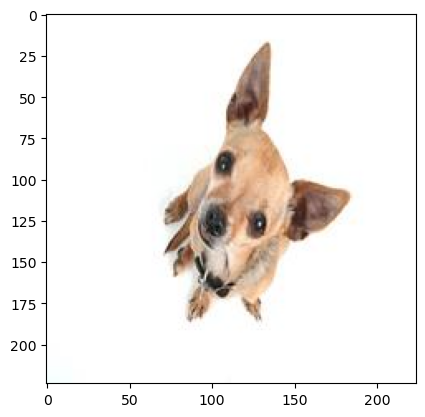


Top 5 predictions:
Chihuahua: 78.81%
toy terrier: 14.70%
miniature pinscher: 1.13%
muzzle: 0.76%
Mexican hairless: 0.28%


In [55]:
# load fresh pre-trained ResNet18 without modifications
model_raw = models.resnet18(weights="IMAGENET1K_V1")
model_raw = model_raw.to(device)
model_raw.eval()  # set to evaluation mode

# get ImageNet class labels
IMAGENET_CLASSES_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

# get ImageNet class mappings
response = requests.get(IMAGENET_CLASSES_URL)
imagenet_classes = [line.strip() for line in response.text.splitlines() if line.strip()]

def predict_image_raw(model, image_path, device):
    """Show and predict a single image using raw ResNet18."""
    
    # set model to evaluation mode
    model.eval()
    
    # load and display image
    img = custom_loader(image_path)
    plt.imshow(img)
    plt.show()

    # preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # get prediction
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        # get top 5 predictions
        top5_prob, top5_idx = torch.topk(prob, 5)
    
    # get class names and probabilities
    predictions = []
    for i in range(5):
        class_name = imagenet_classes[top5_idx[0][i]]
        probability = top5_prob[0][i].item()
        predictions.append((class_name, probability))
    
    return predictions

# use the function to predict one image
test_image_path = PATH_DATA_PROCESSED / "test" / "chihuahua" / "img_1_144.jpg"
predictions = predict_image_raw(model_raw, test_image_path, device)
print("\nTop 5 predictions:")
for class_name, confidence in predictions:
    print(f"{class_name}: {confidence:.2%}")

Cool! It did well! But that one's an easy picture.

FIXME: I should export testing the unchanged ResNet18 to an individual notebook.

## Baseline Model: ResNet18 Without Any Modification

First model to test for this job: ResNet18

### Why ResNet18?

I train the models locally on my machine.
ResNet18 is relative lightweight, but still powerful, and suited for training
locally on my machine.
If that one doesn't do the job, I will have to try larger models.
In case I need more compute then, I will switch to a remote host.

Another reason to start with ResNet18 is that the
data set just contains about 6000 images in total, which is not that large.
A smaller model may be more suitable for transfer learning here, as it is less
prone to overfit and may handle the rather small number of images better.

### Establishing a Baseline

Before tuning hyper parameters, I will fine-tune this ResNet18 without any
modification.
Its performance will then serve as the baseline in this comparison.
Subsequently, variations of this model will be trained.
For example, I will introduce dropout and extra layers.
These modified versions' performance will be compared to the baseline as well as
to another, and finally the best performing model will be selected.

### Apply Minimal Data Transformations

Apply a simplified minimal data transformation pipeline to the images.
It is considered simplified or rather minimal, because it only does the
absolute minimum: Convert the images to tensors and normalize their pixel
values.
Here, the pixel values are normalized according to the ImageNet mean values.
This is done, because the ResNet18 was pre-trained on ImageNet.
Resizing to 224 times 224 pixels was done previously during data preparation.

Such a minimal transformation pipeline is suitable for establishing a baseline
performance.
A more comprehensive transformation pipeline can later be applied to try to
increase the model's performance.
Introducing further transformations such as:

- geometric transformations (rotation, scaling, cropping)
- color modifications (brightness, contrast, saturation)
- random transformations (flips, perspective changes)

often helps improving model robustness and generalization and
preventing overfitting.

In [29]:
# define image transformations - simplified first
transform = transforms.Compose([
    # conver PIL images to PyTorch tensor and scale pixel value range to 0-1
    transforms.ToTensor(),
    # normalize image image according to ImageNet statistics
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def custom_loader(path):
    """Custom image loader that forces image reading in RGB mode."""
    try:
        # force RGB mode during initial open
        img = Image.open(path).convert("RGB")
        return img
    except Exception as e:
        print(f"Error loading image {path}: {str(e)}")
        # return a default image as fallback with mean values matching ImageNet
        return Image.new("RGB", (224, 224), (128, 128, 128))

# recreate datasets with new loader and transforms
train_dataset = datasets.ImageFolder(
    PATH_DATA_TRAIN,
    loader=custom_loader,
    transform=transform
)
test_dataset = datasets.ImageFolder(
    PATH_DATA_TEST,
    loader=custom_loader,
    transform=transform
)

# create dataloaders
# batch size of 32 often leads to good generalization and fits my local memory
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
# print some basic info
print(f"number of training images: {len(train_dataset)}")
print(f"number of test images: {len(test_dataset)}")
print(f"classes: {train_dataset.classes}")

number of training images: 4730
number of test images: 1183
classes: ['chihuahua', 'muffin']


### Set Up Transfer Learning Pipeline using ResNet18 and Fine-Tune

In [30]:
# load pre-trained ResNet18 to an object
# this model was pre-trained on ImageNet on 1000 classes
model_baseline = models.resnet18(weights="IMAGENET1K_V1")

# freeze all layers
# this preserves the feature extraction capabilities learned from ImageNet
for param in model_baseline.parameters():
    param.requires_grad = False

# modify the final layer for binary classification
# this replaces the final fully connected layer (fc) (hence: model.*fc*)
# the original fc had 1000 output probabilities (bc. trained on 1000 classes)
# here, there's just two classes (muffins and chihuahuas) -> replace
# get number of input features to fc
num_features = model_baseline.fc.in_features
# replace with new layer matching input features and output classes
model_baseline.fc = nn.Linear(num_features, 2)  # 2 classes: muffin and chihuahua

# move model to GPU
model_baseline = model_baseline.to(device)

In [31]:
# define loss function and optimizer
# Cross Entropy Loss is well suited and widely used for classification problems
criterion = nn.CrossEntropyLoss()

# only optimize the parameters of the final layer since others are frozen
# start with a static learning rate (lr) of 0.001
optimizer = optim.Adam(model_baseline.fc.parameters(), lr=0.001)

In [38]:
def train_one_epoch(model, train_loader, criterion, optimizer, device): 
    """Train the model for one epoch."""
    
    # set model to training mode
    model.train()
    # initialize running loss and accuracy
    running_loss = 0.0 # accumulator for loss across batches
    correct = 0 # accumulator for correct predictions across batches
    total = 0 # accumulator for total predictions across batches

    # iterate over the batches of training data
    for inputs, labels in train_loader:
        # move each batch of data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero / reset the parameter gradients from previous bachward passes
        optimizer.zero_grad()
        
        # forward pass
        # get model predictions
        outputs = model(inputs)
        # compute loss
        loss = criterion(outputs, labels)
        
        # backward pass
        # compute gradients
        loss.backward()
        # update model parameters / weights
        optimizer.step()
        
        # accumulate loss and statistics
        # accumulate batch loss
        running_loss += loss.item()
        # get predicted class
        _, predicted = outputs.max(1)
        # accumulate total predictions
        total += labels.size(0)
        # accumulate correct predictions
        correct += predicted.eq(labels).sum().item()
    
    # calculate epoch statistics
    # average loss over all batches
    epoch_loss = running_loss / len(train_loader)
    # calculate accuracy
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [33]:
def validate(model, val_loader, criterion, device):
    """Validate the model."""
    
    # set model to evaluation mode
    model.eval()
    # initialize running loss and accuracy
    val_loss = 0.0
    all_labels = []
    all_preds = []
    all_probs = []
    
    # iterate over the batches of validation data
    with torch.no_grad():
        
        # iterate over the batches of validation data
        for inputs, labels in val_loader:
            
            # move each batch of data to device
            inputs, labels = inputs.to(device), labels.to(device)
            # get model predictions
            outputs = model(inputs)
            # compute loss
            loss = criterion(outputs, labels)
            
            # accumulate loss
            val_loss += loss.item()
            
            # get predictions and probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            # collect all predictions and labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            
            
    # calculate metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100. * accuracy_score(all_labels, all_preds)
    val_roc_auc = roc_auc_score(all_labels, all_probs)
    val_f1 = f1_score(all_labels, all_preds)
    
    return {
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_roc_auc': val_roc_auc,
        'val_f1': val_f1
    }

In [67]:
def evaluate_model(model_name, validation_results, include_model_info=False):
    """
    Summarize model performance across validation results.
    
    Args:
        model_name (str): name of the model for identification
        history (dict): dictionary containing training history
            each dictionary should have 'train_loss', 'train_acc', 'val_metrics'
    
    Returns:
        dict: summary statistics for each metric (mean ± std)
    """
    # collect metrics
    metrics = {
        'val_loss': [],
        'val_acc': [],
        'val_roc_auc': [],
        'val_f1': []
    }
    
    # collect metrics from all validation results
    for result in validation_results:
        metrics['val_loss'].append(result['val_loss'])
        metrics['val_acc'].append(result['val_acc'])
        metrics['val_roc_auc'].append(result['val_roc_auc'])
        metrics['val_f1'].append(result['val_f1'])
    
    # initialize summary dictionary
    summary = {}
    
    # include info about model if desired
    if include_model_info:
        summary['model'] = model_name
    else:
        
        
    # compute mean and standard deviation and add to summary
    summary['val_loss'] = f"{mean(metrics['val_loss']):.4f} ± {stdev(metrics['val_loss']):.4f}"
    summary['val_acc'] = f"{mean(metrics['val_acc']):.2f}% ± {stdev(metrics['val_acc']):.2f}%"
    summary['val_roc_auc'] = f"{mean(metrics['val_roc_auc']):.4f} ± {stdev(metrics['val_roc_auc']):.4f}"
    summary['val_f1'] = f"{mean(metrics['val_f1']):.4f} ± {stdev(metrics['val_f1']):.4f}"
    
    return summary

In [35]:
# make class for early stopping
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self,
        patience=7,
        min_delta=0,
        path='checkpoint.pt'
    ):
        """
        Args:
            patience (int): How many epochs to wait before stopping when loss is
            not improving
            min_delta (float): Minimum change in the monitored quantity to 
            qualify as an improvement
            path (str): Path for the checkpoint to be saved to
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path
        self.best_model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
    
    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        torch.save(model.state_dict(), self.path)
        self.best_model = model.state_dict()

In [59]:
# number of epochs to train for
# 50 epochs is commonly used in transfer learning
# smaller number of epoch may be sufficient as well, but
# use a larger number, because early stopping is applied
n_epochs = 50

# initialize early stopping object
    # patience
    # 7 is within range of 5 - 20 commonly used in practice
    # has enough buffer to prevent stopping too early due to temporary plateaus
    # not too large to waste computational resources
    # min_delta
    # 0.001 is commonly used in practice
    # small enough to catch meaninful improvements
early_stopping_baseline = EarlyStopping(
    patience=7,
    min_delta=0.001,
    path=PATH_MODELS / "model_checkpoint_baseline.pt"
)

# initialize dictionary for training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_metrics': []
}

# train and validate for n_epochs
for epoch in range(n_epochs):
    
    # train for one epoch
    train_loss, train_acc = train_one_epoch(
        model_baseline,
        train_loader,
        criterion,
        optimizer,
        device
    )
    
    # validate 
    val_metrics = validate(
        model_baseline,
        test_loader,
        criterion,
        device
    )
    
    # store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_metrics'].append(val_metrics)
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(
        f"Val Loss: {val_metrics['val_loss']:.4f}, "
        f"Val Acc: {val_metrics['val_acc']:.2f}%"
    )
    print("-" * 50)
    
    # check improvement in val loss for early stopping
    early_stopping_baseline(val_metrics['val_loss'], model_baseline)
    
    # check if early stopping is triggered
    # if there is no improvement for longer than patience, stop training
    if early_stopping_baseline.early_stop:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        # load best model from checkpoint
        model_baseline.load_state_dict(early_stopping_baseline.best_model)
        break

Epoch 1/50:
Train Loss: 0.0213, Train Acc: 99.37%
Val Loss: 0.0394, Val Acc: 98.65%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0231, Train Acc: 99.30%
Val Loss: 0.0236, Val Acc: 98.99%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0168, Train Acc: 99.37%
Val Loss: 0.0478, Val Acc: 98.14%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0191, Train Acc: 99.15%
Val Loss: 0.0258, Val Acc: 99.15%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0193, Train Acc: 99.28%
Val Loss: 0.0290, Val Acc: 98.90%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0172, Train Acc: 99.45%
Val Loss: 0.0274, Val Acc: 98.90%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0257, Train Acc: 99.07%
Val Loss: 0.0281, Val Acc: 98.73%
--------------------------------------------------
Epoch 8/50:
Train Loss: 0.0197, Train Acc: 99.32%
Val L

While the model was trained, early stopping was triggered.
Patience was set to 7, so the model had its best performance 7 epochs before
stopping, and was last loaded to the checkpoint then.
After early stopping, the model was loaded 
to the object `model_baseline` from the checkpoint.

To get an idea of the model's performance, let's have a look at some metrics
from the k-fold cross validation which were computed during training.
The test set will not be used yet, but only once in the very end.

In [79]:
# get evaluation report
# these are the averages of the k-fold cross validation
evaluate_model(
    model_baseline,
    history["val_metrics"],
    include_model_info=False
)

{'val_loss': '0.0308 ± 0.0078',
 'val_acc': '98.82% ± 0.33%',
 'val_roc_auc': '0.9996 ± 0.0000',
 'val_f1': '0.9871 ± 0.0036'}

#### Test Querying the Model

Great! We finally have a trained model!
Now it is time to check if the model can be used to make a prediction.

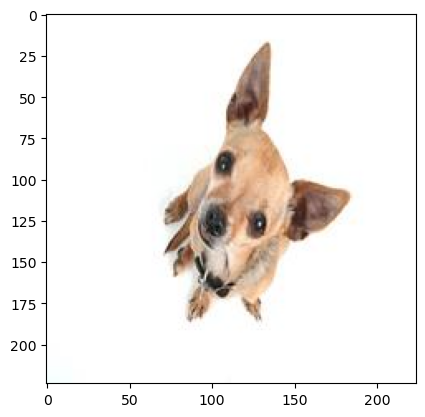

Prediction: chihuahua with 100.00% confidence


In [57]:
def predict_image(model, image_path, device):
    """Show and predict a single image."""
    
    # set model to evaluation mode
    model.eval()
    
    # load and display image
    img = custom_loader(image_path)
    plt.imshow(img)
    plt.show()

    # preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # get prediction
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.nn.functional.softmax(output, dim=1)
        pred_idx = output.argmax(dim=1).item()
    
    # get class name and probability
    class_name = train_dataset.classes[pred_idx]
    probability = prob[0][pred_idx].item()
    
    return class_name, probability

# use the function to predict one image
test_image_path = PATH_DATA_PROCESSED / "test" / "chihuahua" / "img_1_144.jpg"
pred_class, confidence = predict_image(model_baseline, test_image_path, device)
print(f"Prediction: {pred_class} with {confidence:.2%} confidence")

Amazing! It is 100.00% confident about this :D
The model can be used, and made one correct prediction.

### Hyper Parameter Tuning

- I will tune the following hyper parameters of the model:
  - learning rate
  - dropout
  - hidden layers
- Hyper parameter tuning can be done sequentially one after another,
or it can be done using more sophisticated methods, like for example a grid
search across all parameters or Bayesian optimization.
- Here, I will do it sequential.
- In this project, I don't train small statistical models or tree based 
models, which are still very fast to train.
Instead I fine tune deep convolutional neural networks.
Beyond that, I train them locally on my personal laptop running an Apple Silicon
chip. While that's already powerful, it doesn't compare to a (remote) machine
with multiple GPUs specifically set up to train these networks.
- A grid search would be computationally expensive and very time-consuming on
my laptop.
- While sequential tuning comes with some disadvantages, including not exploring
all specified combinations and potentially getting stuck in local optima, it
also comes with some advantages. For example, it allows focusing available
computing power on promising configurations, and to better understand how each
parameter affects the model.
- The baseline model is already performing well (98.82% ± 0.33% validation
accuracy), so we can make targeted improvements.
- Learning rate is typically the most important hyperparameter to tune first,
as it has the largest impact on model performance, so we'll start with that.

### k-fold Cross Validation

- For hyper parameter tuning, k-fold cross validation is a commonly applied
technique.
- Here, however, it is not implemented. Instead, a single train / validation
split is used.
- For this specific case (pre-trained ResNet18 on a binary classification task),
k-fold cross validation is not strictly necessary.
- The dataset contains about 4,730 training images, which is reasonably large
for binary classification.
- Pre-trained models tend to be more stable in their performance.
For them, this amount of data is typically
sufficient for reliable validation without k-fold.
- The small standard deviation in the model's validation accuracy
(98.82% ± 0.33%) supports this expectation of a stable performance.
- The main variability comes from the final layer adaptation,
which is less sensitive to fold variations
- Beyond that, using K-fold would require training the model k times
(typically 5 or 10), which would further multiply the computational cost.
Since I'm training locally on my laptop, I have less options for
parallelization, this also means a significant increase in training time.
- k-fold would be more important if I had used a smaller data set, a custom
architecture or if there was the need for very high performance or
very precise performance estimates.

### Conclusion

- The followed approach of sequential hyper parameter tuning without k-fold
cross validation provides a good balance between reliability and computational
efficiency for this specific use case.
- A more sophisticated hyper parameter optimization strategy would provide 
more reliable performance estimates and could result in increased model
performance.
- However, it would come at a greatly increased computational cost and training
time, which is not justified for this specific use case.






## More info to add about the order of tuning

I asked Perplexity about the optimal strategy and order of fine tuning these
hyper parameters, because Sonnet recommended me to adjust learning rate and
dropout again after I added layers.
I thought that was redundant, and asked for a more optimal strategy, because I
don't want to repeat the steps I already did before (starting with lr, then do,
then layer, then ld and do again?!?).
The answer I got first referred to the situation when you build a neural
network from the ground up.
There, you first need to take care of the architecture itself.
I realized that my question was not specific enough, and that I needed to
specify, so I asked about fine tuning a ResNet18, and this is what I got:

Beim Fine-Tuning eines ResNet18 sieht die optimale Strategie etwas anders aus:

## Empfohlene Tuning-Reihenfolge

1. **Learning Rate**
- Dies ist beim Fine-Tuning der wichtigste Parameter
- Sollte als erstes optimiert werden, da er den größten Einfluss hat
- Typischerweise wird eine kleine Learning Rate verwendet, um die vortrainierten
Gewichte nur leicht anzupassen

2. **Dropout Rate**
- Nach der Learning Rate sollte die Dropout-Rate in den neu hinzugefügten Fully
Connected Layers optimiert werden
- Ein typischer Startwert ist 0.5

3. **Architektur-Modifikationen**
- Erst danach solltest du zusätzliche Fully Connected Layers hinzufügen
- Diese können verschiedene Output-Größen haben, typischerweise mit 256 Neuronen
beginnend

## Wichtige Hinweise
- Die ursprünglichen ResNet18-Layer sollten während des Fine-Tunings teilweise
eingefroren werden
- Batch Normalization sollte nach jedem neu hinzugefügten Layer verwendet werden
- Die Learning Rate sollte für die neu hinzugefügten Layer etwa 10-mal höher
sein als für die vortrainierten Layer

Diese Reihenfolge minimiert die Notwendigkeit von mehrfachen Tuning-Durchläufen
und berücksichtigt die spezifischen Anforderungen beim Fine-Tuning eines
vortrainierten Modells


Then I asked why it recommended this order:


Die empfohlene Reihenfolge beim Fine-Tuning von ResNet18 (Learning Rate
→ Dropout → Architektur-Modifikationen) basiert auf mehreren wichtigen
Erkenntnissen aus der Forschung:

## Learning Rate als erster Parameter

Die Learning Rate wird als erster Parameter optimiert, weil:
- Sie den größten Einfluss auf die Modellkonvergenz und -leistung beim
Fine-Tuning hat
- Eine zu große Learning Rate die vortrainierten Gewichte zu stark verändern und
damit das wertvolle Vorwissen zerstören könnte
- Neuere Forschung zeigt, dass die Learning Rate-Optimierung fundamental für
erfolgreichen Wissenstransfer ist

## Dropout als zweiter Schritt

Dropout folgt als zweiter Parameter, da:
- Die Dropout-Rate stark von der gewählten Learning Rate abhängt
- Sehr hohe Dropout-Raten beim Training von Grund auf problematisch sind, aber
beim Fine-Tuning effektiv sein können
- Dropout hilft, die Balance zwischen dem Erhalt des vortrainierten Wissens und
der Anpassung an neue Daten zu finden

## Architektur-Modifikationen zuletzt

Die Architektur wird als letztes angepasst, weil:
- ResNet18 bereits eine optimierte Architektur besitzt
- Architektur-Änderungen am Ende des Netzwerks (nach dem Global Average Pooling)
am effektivsten sind
- Die vorherige Optimierung von Learning Rate und Dropout eine stabilere Basis
für architektonische Änderungen schafft

## Wissenschaftliche Grundlage
Diese Reihenfolge wird durch aktuelle Forschung gestützt:
- Studien zeigen, dass die Learning Rate der kritischste Parameter beim
Fine-Tuning ist
- Neuere Untersuchungen bestätigen, dass sehr hohe Dropout-Raten beim
Fine-Tuning vortrainierter Modelle besonders effektiv sind
- Die lineare Konnektivität beim Fine-Tuning macht diese Reihenfolge besonders
effektiv

Diese Reihenfolge ist also keine willkürliche Wahl, sondern basiert auf
empirischen Erkenntnissen und theoretischen Überlegungen aus der aktuellen
Forschung.



## Tune Learning Rate

Now that a baseline performance is established,
let's see if we can make some improvements to that.

Learning rate is typically the most important hyper parameter to tune first,
as it has the largest impact on model performance.

Now, we'll test three different learning rates (0,0001, 0.001, 0.01)
using the same model architecture and training setup as for the baseline.

In [98]:
def train_with_learning_rate(lr, n_epochs=50):
    """
    Train model with specified learning rate and return validation results.
    """
    
    # initialize model (same as baseline)
    model = models.resnet18(weights="IMAGENET1K_V1")
    
    # freeze all layers
    for param in model.parameters():
        param.requires_grad = False
    
    # modify the final layer for binary classification
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    
    # move model to GPU
    model = model.to(device)
    
    # initialize with specified learning rate
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # initialize early stopping
    early_stopping = EarlyStopping(
        patience=7,
        min_delta=0.001,
        path=PATH_MODELS / f"model_checkpoint_lr_{lr}.pt"
    )
    
    # initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_metrics': []
    }
    
    # train and validate
    for epoch in range(n_epochs):
        
        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device
        )
        
        val_metrics = validate(
            model,
            test_loader,
            criterion,
            device
        )
        
        # store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_metrics'].append(val_metrics)
        
        # print epoch information
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(
            f"Val Loss: {val_metrics['val_loss']:.4f}, "
            f"Val Acc: {val_metrics['val_acc']:.2f}%"
        )
        print("-" * 50)
        
        # early stopping check
        early_stopping(val_metrics['val_loss'], model) # returns True or False
        # if early stopping is triggered, break the loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            
            # load best model from checkpoint
            model.load_state_dict(early_stopping.best_model)
            break
    
    return history

In [114]:
# test different learning rates
learning_rates = [0.0001, 0.001, 0.01]  # common range for Adam optimizer
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    print("-" * 50)
    history = train_with_learning_rate(lr)
    results[lr] = evaluate_model(f"ResNet18_(lr={lr})", history["val_metrics"])
    print("-" * 50)
    print(f"Results for lr={lr}:")
    for key, value in results[lr].items():
        print(f"{key}: {value}")
    print("-" * 50)


Training with learning rate: 0.0001
--------------------------------------------------
Epoch 1/50:
Train Loss: 0.3790, Train Acc: 87.97%
Val Loss: 0.2207, Val Acc: 96.79%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.1833, Train Acc: 97.15%
Val Loss: 0.1320, Val Acc: 98.14%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.1258, Train Acc: 97.86%
Val Loss: 0.0939, Val Acc: 98.48%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.1005, Train Acc: 97.97%
Val Loss: 0.0772, Val Acc: 98.48%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0845, Train Acc: 98.18%
Val Loss: 0.0657, Val Acc: 98.65%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0788, Train Acc: 98.08%
Val Loss: 0.0567, Val Acc: 98.99%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0680, Train Acc: 98.41%
Val Loss: 0.0526, Val Acc: 98.90%
------------------

The models will be selected based on best ROC AUC score, which is well suited
for binary classification.
It is classification threshold independent,
meaning that it provides one single score for model performance across all
possible classification thresholds.
F1 score is great when you need a balance between precision and recall, but it
still depends on the classification threshold.
Also, it handles class imbalances well,
even though the muffin vs. chihuahua data set is rather balanced 
(~46% muffins, ~54% chihuahuas)).

In [141]:
# collect roc auc scores across all learning rates
roc_auc_scores_lr = pd.DataFrame([
    {
        "learning_rate": lr,
        "roc_auc": float(results[lr]["val_roc_auc"].split(" ± ")[0]),
        "std": float(results[lr]["val_roc_auc"].split(" ± ")[1])
    }
    for lr in results
])

roc_auc_scores_lr

,learning_rate,roc_auc,std
0,0.0001,0.9994,0.0008
1,0.0010,0.9997,0.0001
2,0.0100,0.9996,0.0001


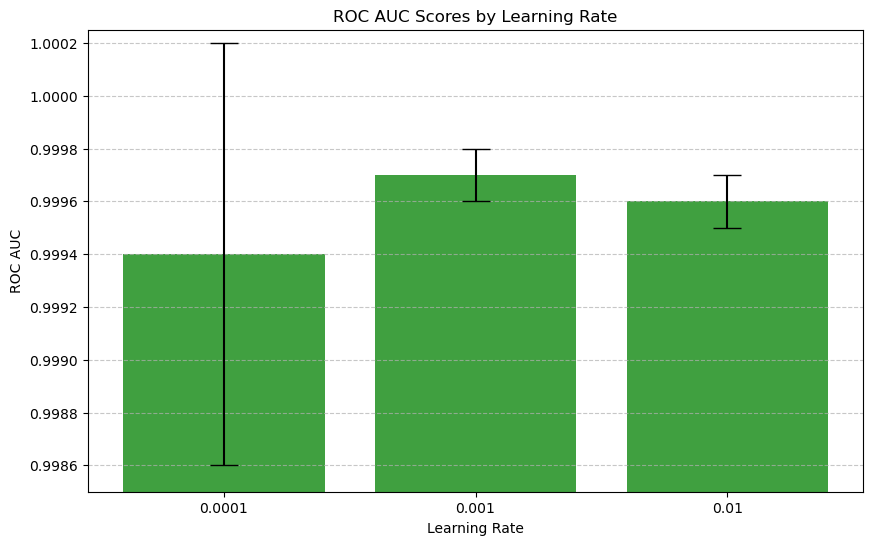

In [166]:
# make bar plot with error bars
plt.figure(figsize=(10, 6))
plt.bar(
    roc_auc_scores_lr["learning_rate"].astype(str),
    roc_auc_scores_lr["roc_auc"],
    yerr=roc_auc_scores_lr["std"],
    capsize=10,
    color="green",
    alpha=0.75
)

# customize plot
plt.title("ROC AUC Scores by Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("ROC AUC")

# adjust y-axis to better show the differences
plt.ylim(0.9985, 1.00025)

# add horizontal grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

First of all, it can be seen that there is a mathematical impossibility here.
The mean ROC AUC at a learning rate of 0.0001 is 0.9994, and the standard
deviation is 0.0008.
0.9994 + 0.0008 = 1.0002 > 1.0.
This likely happened because the values come from mean ± standard deviation
calculations across validation results.
While the individual ROC AUC scores were all ≤ 1.0, the standard deviation
calculation doesn't account for this bound.
It is, however, not much of an issue right here, and it can be ignored for now.

Apart from that, the model's performance is very similar and close to optimal
regarding ROC AUC at all learning rates.
The differences are minimal.
Still, at a learning rate of 0,001, the model's ROC AUC becomes maximal 
at 0.9997 with standard deviation of 0.0001
indicates a stable performance estimate.

The unmodified model also had the same learning rate of 0.001, since that is 
the default learning rate of the Adam optimizer.
It had a ROC AUC of 0.9996 with a standard deviation of 0.0000,
so both values differs by just 0.0001, which is a minimal deviation and can
likely be attributed to to the stochastic elements of training neural networks.

Based on this test, here, the learning rate will be set to 0.001 from now on.
So actually nothing really changed about the model after tuning this hyper
parameter.
Still, this result could have been different, and any other learning rate could
have come out on top, so it's good to have done the test.

## Add Dropout Layers

Now, the dropout hyper parameter will be tuned.
Of the tested learning rates, 0.001 was determined to be optimal,
and will be used from now on.
Four dropout probabilities will be used here: 0.2, 0.3, 0.4 and 0.5.
This range of probabilities is commonly found in practice.

In [172]:
# make class for dropout
class ResNet18_dropout(nn.Module):
    """ResNet18 with dropout layer."""
    def __init__(self, dropout_rate):
        super(ResNet18_dropout, self).__init__()
        self.model = models.resnet18(weights="IMAGENET1K_V1")
        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),  # add dropout layer
            nn.Linear(num_features, 2)  # 2 classes: muffin and chihuahua
        )

    def forward(self, x):
        return self.model(x)

In [174]:
# test different dropout rates
dropout_rates = [0.2, 0.3, 0.4, 0.5] # common range for dropout probabilities
lr = 0.001 # best learning rate from previous tuning
results_dropout = {}

def train_with_dropout(dropout_rate, lr=0.001, n_epochs=50):
    """
    Train model with specified dropout rate and return validation results.
    """
    
    # initialize model with dropout and send to device
    model = ResNet18_dropout(dropout_rate=dropout_rate).to(device)
    
    # initialize optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # initialize early stopping
    early_stopping = EarlyStopping(
        patience=7,
        min_delta=0.001,
        path=PATH_MODELS / f"model_checkpoint_dropout_{dropout_rate}.pt"
    )
    
    # initialize history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_metrics': []
    }
    
    # train and validate
    for epoch in range(n_epochs):
        train_loss, train_acc = train_one_epoch(
            model,
            train_loader,
            criterion,
            optimizer,
            device
        )
    
        val_metrics = validate(
            model,
            test_loader,
            criterion,
            device
        )
        
        # store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_metrics'].append(val_metrics)
        
        # print epoch information
        print(f"Epoch {epoch+1}/{n_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(
            f"Val Loss: {val_metrics['val_loss']:.4f}, "
            f"Val Acc: {val_metrics['val_acc']:.2f}%"
        )
        print("-" * 50)
        
        # early stopping check
        early_stopping(val_metrics['val_loss'], model) # returns True or False
        # if early stopping is triggered, break the loop
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            
            # load best model from checkpoint
            model.load_state_dict(early_stopping.best_model)
            break
    
    return history

In [175]:
# train models with different dropout rates
for dropout_rate in dropout_rates:
    print(f"\nTraining with dropout rate: {dropout_rate}")
    print("-" * 50)
    history = train_with_dropout(dropout_rate)
    results_dropout[dropout_rate] = evaluate_model(
        f"ResNet18_dropout_{dropout_rate}",
        history["val_metrics"],
    )
    print("-" * 50)
    print(f"Results for dropout rate={dropout_rate}:")
    for key, value in results_dropout[dropout_rate].items():
        print(f"{key}: {value}")
    print("-" * 50)


Training with dropout rate: 0.2
--------------------------------------------------
Epoch 1/50:
Train Loss: 0.1441, Train Acc: 94.65%
Val Loss: 0.2624, Val Acc: 90.87%
--------------------------------------------------
Epoch 2/50:
Train Loss: 0.0804, Train Acc: 96.79%
Val Loss: 0.0596, Val Acc: 97.72%
--------------------------------------------------
Epoch 3/50:
Train Loss: 0.0657, Train Acc: 97.67%
Val Loss: 0.2313, Val Acc: 91.72%
--------------------------------------------------
Epoch 4/50:
Train Loss: 0.0414, Train Acc: 98.48%
Val Loss: 0.2041, Val Acc: 94.42%
--------------------------------------------------
Epoch 5/50:
Train Loss: 0.0483, Train Acc: 98.37%
Val Loss: 0.0884, Val Acc: 96.53%
--------------------------------------------------
Epoch 6/50:
Train Loss: 0.0413, Train Acc: 98.46%
Val Loss: 0.0418, Val Acc: 98.65%
--------------------------------------------------
Epoch 7/50:
Train Loss: 0.0227, Train Acc: 99.09%
Val Loss: 0.0433, Val Acc: 98.65%
----------------------

In [250]:
# collect roc auc scores across all dropout rates
roc_auc_scores_dropout = pd.DataFrame([
    {
        "dropout_rate": dropout_rate,
        "roc_auc": float(results_dropout[dropout_rate]["val_roc_auc"].split(" ± ")[0]),
        "std": float(results_dropout[dropout_rate]["val_roc_auc"].split(" ± ")[1])
    }
    for dropout_rate in results_dropout
])

roc_auc_scores_dropout

,dropout_rate,roc_auc,std
0,0.2,0.9975,0.0024
1,0.3,0.9975,0.0025
2,0.4,0.9974,0.0021
3,0.5,0.9965,0.0041


In [251]:
roc_auc_scores_dropout = pd.concat(
    [
        roc_auc_scores_lr[roc_auc_scores_lr["learning_rate"] == 0.001][["roc_auc", "std"]],
        roc_auc_scores_dropout,
    ]
).reset_index(drop=True)

roc_auc_scores_dropout.loc[0, "dropout_rate"] = 0.0

roc_auc_scores_dropout

,roc_auc,std,dropout_rate
0,0.9997,0.0001,0.0
1,0.9975,0.0024,0.2
2,0.9975,0.0025,0.3
3,0.9974,0.0021,0.4
4,0.9965,0.0041,0.5


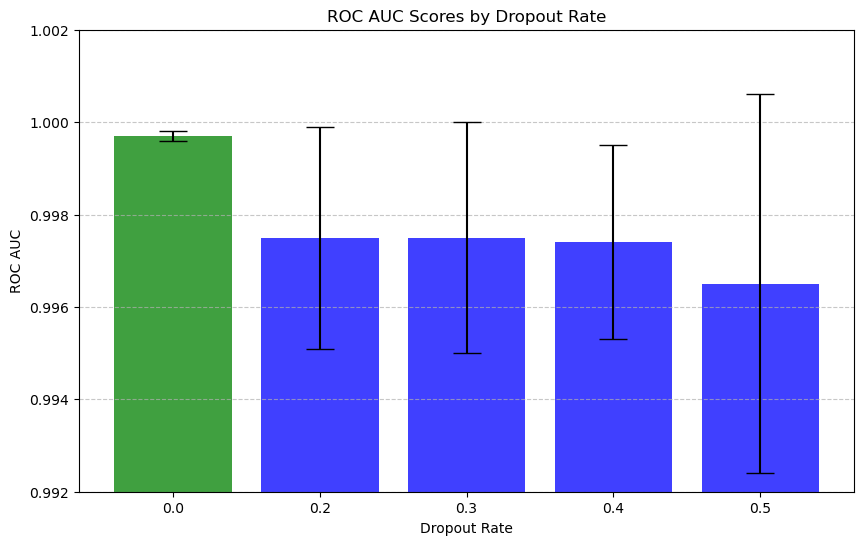

In [261]:
# make bar plot with error bars
plt.figure(figsize=(10, 6))

# create colors list: first green blue, rest blue
colors = ["green"] + ["blue"] * (len(roc_auc_scores_dropout) - 1)

plt.bar(
    roc_auc_scores_dropout["dropout_rate"].astype(str),
    roc_auc_scores_dropout["roc_auc"],
    yerr=roc_auc_scores_dropout["std"],
    capsize=10,
    color=colors,
    alpha=0.75
)

# customize plot
plt.title("ROC AUC Scores by Dropout Rate")
plt.xlabel("Dropout Rate")
plt.ylabel("ROC AUC")

# adjust y-axis to better show the differences
plt.ylim(0.992, 1.002)

# add horizontal grid lines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

The previous best model's performance from tuning the learning rate is
included here.
It is still plotted in green.
The new results from tuning the dropout rate are plotted in blue.

Again, there is one case in which the mean and the standard deviation add up to
a value slightly larger than one, but that's not too much of an issue, because
it happened because of averaging across the batches.
Also, the different model's performance is very similar across all dropout rates.

However, none of the model's performance matches the ResNet18 baseline performance
without any dropout.

Based on this, the optimal dropout rate for this setting is 0.0, and no dropout
will be used here.

## Add Additional Inner Layers

The final thing to tune about the network is experimenting with changes in
architecture.
ResNet18 is already an optimized architecture, and has limits to how and where
layers can be added to it.

- also experiment with different sizes (e.g., 64, 128, 256 units)

## Add Additional Transformations

- like augmentations etc.

## Comparison

- baseline model
- with dropout
- with extra inner layers
- with both dropout and extra inner layers

Compare the metrics from k-fold cross validation.

This is not for test set yet.

## Final Validation

After selecting the best model, then and only then use the test set to get the
final performance metrics.
This provides an unbiased estimate of real-world performance metrics.